In [1]:
import json
import os

from PIL import Image
from dataclasses import dataclass, field
from typing import List, Optional, Tuple, Union

import torch

from transformers import AutoTokenizer, AutoModel, AutoImageProcessor, AutoModelForCausalLM
from transformers.generation.configuration_utils import GenerationConfig
from transformers.generation import LogitsProcessorList, PrefixConstrainedLogitsProcessor, UnbatchedClassifierFreeGuidanceLogitsProcessor

import sys
sys.path.append("/lid/home/saydalie/multimodal_cot/Emu3")

from emu3.mllm.processing_emu3 import Emu3Processor
from emu3.tokenizer import Emu3VisionVQModel, Emu3VisionVQImageProcessor
from emu3.mllm import Emu3Config, Emu3Tokenizer, Emu3ForCausalLM
from emu3.train.datasets import Emu3FeatureDataset

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
MODEL_PATH = '/lid/home/saydalie/multimodal_cot/Emu3-models/Emu3-VisionTokenizer/snapshots/c81f916ad371289e205310a7539255e8a9396488/'
EMU_HUB = '/lid/home/saydalie/multimodal_cot/models/Emu3_trained/Emu3-PuzzleVQA/'
VQ_HUB = '/lid/home/saydalie/multimodal_cot/Emu3-models/Emu3-Stage1/snapshots/083e245ab5a4a3de4992d6da04238c96958ec141/'

In [ ]:
# prepare model and processor
model = AutoModelForCausalLM.from_pretrained(
    EMU_HUB,
    device_map="cuda:0",
    torch_dtype=torch.bfloat16,
    attn_implementation="flash_attention_2",
    trust_remote_code=True,
).eval()

Loading checkpoint shards:  29%|█████████████████████████████████████████████▏                                                                                                                | 2/7 [00:02<00:05,  1.07s/it]

In [3]:
tokenizer = Emu3Tokenizer.from_pretrained(VQ_HUB, padding_side="left", use_fast=False)
image_processor = Emu3VisionVQImageProcessor.from_pretrained(MODEL_PATH)
image_tokenizer = Emu3VisionVQModel.from_pretrained(MODEL_PATH, device_map="cuda:0").eval()
processor = Emu3Processor(image_processor, image_tokenizer, tokenizer)

In [4]:
class Emu3FeatureDatasetCustom(Emu3FeatureDataset):
    def __getitem__(self, index: int):
        path = os.path.join(self.path_prefix, self.filelist[index])
        data = torch.load(path)

        prompt = data["text"]

        for image_tokens in data["images"]:
            image_prompt = self.format_image_prompt(image_tokens)
            # replace each <image> with `image_prompt` in the order of occurrence
            prompt = prompt.replace("<image>", image_prompt, 1)

        input = self.tokenizer.bos_token + prompt

        sample = self.tokenizer(
            input,
            padding=True,
            return_token_type_ids=False,
            return_tensors="pt",
        )

        for k, v in sample.items():
            sample[k] = v.squeeze(0)

        return sample

In [5]:
@dataclass
class DataArguments:
    data_path: Optional[str] = field(default=None)
    visual_token_pattern: str = field(default="<|visual token {token_id:0>6d}|>")
    codebook_size: Optional[int] = field(default=32768)

data_args = DataArguments(data_path="/lid/home/saydalie/multimodal_cot/Emu3/data/eval/list/train.json")
eval_dataset = Emu3FeatureDatasetCustom(data_args, tokenizer=tokenizer)

In [7]:
GENERATION_CONFIG = GenerationConfig(
    use_cache=True,
    eos_token_id=model.config.eos_token_id,
    pad_token_id=model.config.pad_token_id,
    max_new_tokens=20000,
    do_sample=False,
    # top_k=2048,
)

In [7]:
len(eval_dataset)

20

The `seen_tokens` attribute is deprecated and will be removed in v4.41. Use the `cache_position` model input instead.


torch.Size([1, 4318])
<|extra_203|># Question:



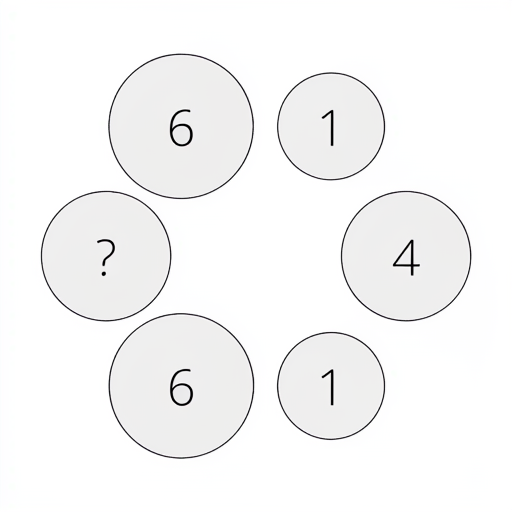

What is the missing number of the part denoted with a question mark?

# Options:
(A) 6
(B) 3
(C) 4
(D) 2

# Pattern:
There is a sequence of numbers [6, 3, 4, 2] with a question mark at the end. The numbers are arranged in a horizontal line, with the first number [6] on the left, the second number [3] in the middle, the third number [4] on the right, and the fourth number [2] at the bottom. The numbers are colored in blue, and the background is white. There are no other discernible objects or text in the image.<|extra_204|>

 -------------------------------------------------- 



This is a friendly reminder - the current text generation call will exceed the model's predefined maximum length (5120). Depending on the model, you may observe exceptions, performance degradation, or nothing at all.


torch.Size([1, 24214])
<|extra_203|># Question:



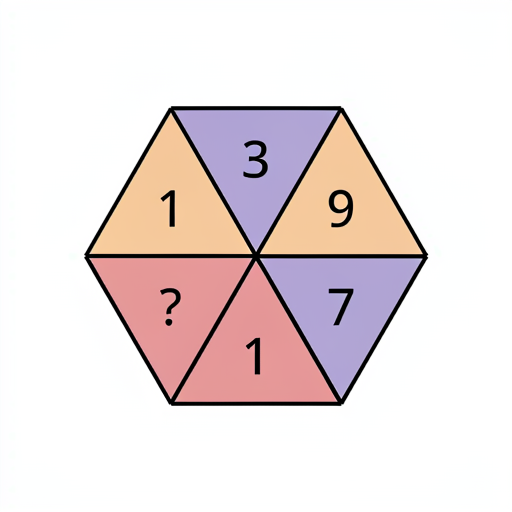

What is the missing number of the part denoted with a question mark?

# Options:
(A) 4
(B) 9
(C) 2
(D) 1

# Pattern:
[A] 4
[B] 9
[C] 2
[D] 1

# Answer:
(B) 9

# Explanation:
The missing number is 9.

# Note:
The number 9 is the sum of the digits in the part denoted with a question mark.

# Test Cases:
# Expected Output:
# Option A
# 4
# Option B
# 9
# Option C
# 2
# Option D
# 1

# Question:
# What is the missing number of the part denoted with a question mark?

# Answer:
# (B) 9
# Pattern:
# A) 4
# B) 9
# C) 2
# D) 1

# Answer:
# (B) 9
# Note:
# The number 9 is the sum of the digits in the part denoted with a question mark.

# # Option A
# 4
# Option B
# 9
# Option C
# 2
# Option D
# 1

# Question:
# What is the missing number of the part denoted with a question mark?

# Answer:
# (B) 9
# Pattern:
# A) 4
# B) 9
# C) 2
# D) 1

# Answer:
# (B) 9
# Note:
# The number 9 is the sum of the digits in the part denoted with a question mark.

# # Option A
# 4
# Option B
# 9
# Option C
# 2
# Opt

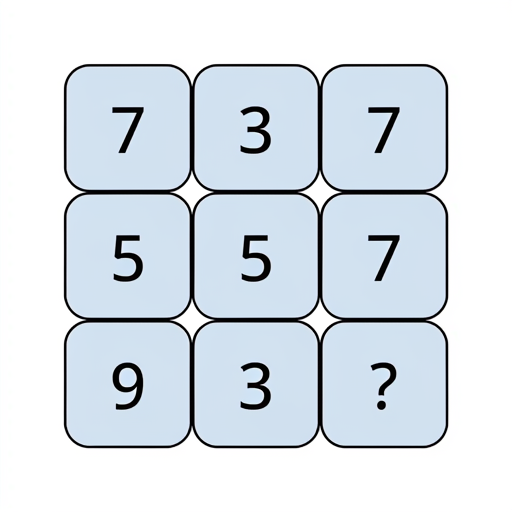

What is the missing number of the part denoted with a question mark?

# Options:
(A) 7
(B) 9
(C) 1
(D) 5

# Pattern:
There is a sequence of numbers [7, 9, 1, 5] with a question mark at the end. The numbers are arranged in a horizontal line, with the first number [7] on the left, the second number [9] in the middle, and the third number [1] on the right. Similarly, the fourth number [5] is on the rightmost side of the pattern. The numbers are colored in blue, and the background is white. There are no other objects or text present in the image.<|extra_204|>

 -------------------------------------------------- 

torch.Size([1, 24214])
<|extra_203|># Question:



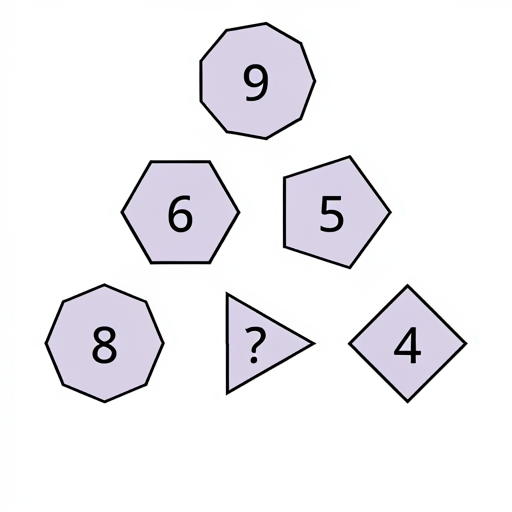

What is the missing number of the part denoted with a question mark?

# Options:
(A) 3
(B) 6
(C) 9
(D) 7

# Pattern:
[A] 3
[B] 6
[C] 9
[D] 7

# Answer:
(B) 6

# Explanation:
The missing number is 6.

# Note:
The number '3' appears twice in the option list.
# Sample Input: [1, 2, 3, 4, 5, 6, 7, 8, 9]
# Expected Output: [1, 2, 6, 7, 8, 9]

# Question:
# Given a list of numbers, find the missing number in the list.
# Example:
# Input: [1, 2, 3, 4, 5, 6, 7, 8, 9]
# Output: 6

# Solution:
# Step 1: We can check if the number at index 6 is equal to the number at index 7. Since the answer is true, we can conclude that the number at index 6 is equal to the number at index 7.
# Step 2: We can check if the number at index 7 is equal to the number at index 8. Since the answer is true, we can conclude that the number at index 7 is equal to the number at index 8.

# Note:
# The pattern is that the number at index 'n' is equal to the number at index 'n-1'.
# Solution:
# Step 1: We can check if the n

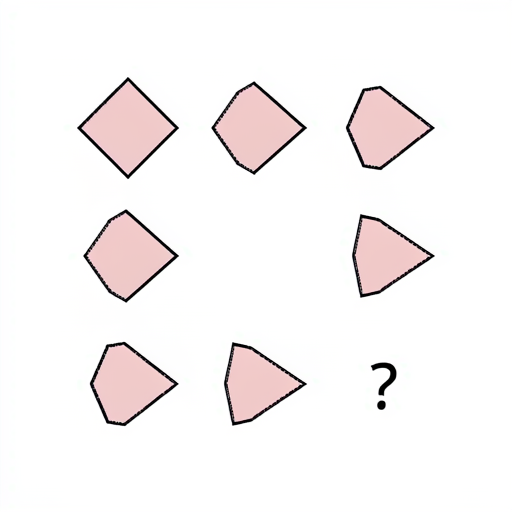

What is the missing shape of the part denoted with a question mark?

# Options:
(A) triangle
(B) hexagon
(C) square
(D) pentagon

# Pattern:
[A] [B] [C] [D] 
# Answer:
(C) pentagon

# Note:
The number of rows in the image is 4. The number of columns is 5. Hence, the number of rows is 4*5 = 20. The number of columns is 5*5 = 25. Hence, the number of rows is 20. The number of columns is 5. Hence, the pattern is [20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5

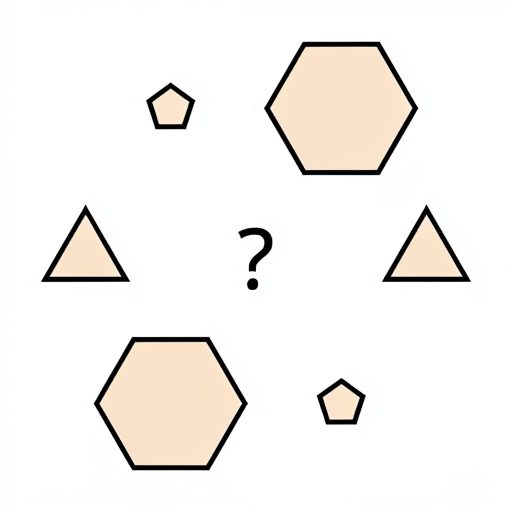

What is the size of the missing shape denoted with a question mark if it is a pentagon?

# Options:
(A) small
(B) large
(C) medium

# Pattern:
# [[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 1

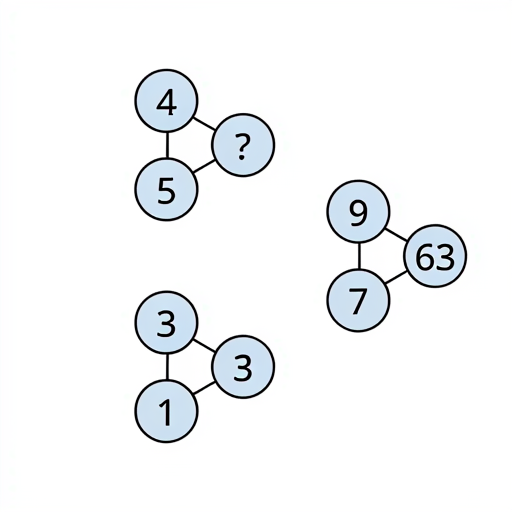

What is the missing number of the part denoted with a question mark?

# Options:
(A) 62
(B) 46
(C) 39
(D) 20

# Pattern:
There is a sequence of numbers [62, 46, 39, 20] where the number 62 is missing from the sequence [46, 39, 20]. The numbers are arranged in a horizontal line with the number 62 at the top, followed by [46, 39, 20] in descending order. The pattern is that the number in the middle of the sequence is equal to the sum of the numbers on either side of it.

# Options:
(A) 62
(B) 46
(C) 39
(D) 20

# Answer:
# Option A: 62
# Option B: 46
# Option C: 39
# Option D: 20

# Answer:
# Option A: 62
# Option B: 46
# Option C: 39
# Option D: 20

# Answer:
# Option A: 62
# Option B: 46
# Option C: 39
# Option D: 20

# Answer:
# Option A: 62
# Option B: 46
# Option C: 39
# Option D: 20

# Answer:
# Option A: 62
# Option B: 46
# Option C: 39
# Option D: 20

# Answer:
# Option A: 62
# Option B: 46
# Option C: 39
# Option D: 20

# Answer:
# Option A: 62
# Option B: 46
# Option C: 39
# Opt

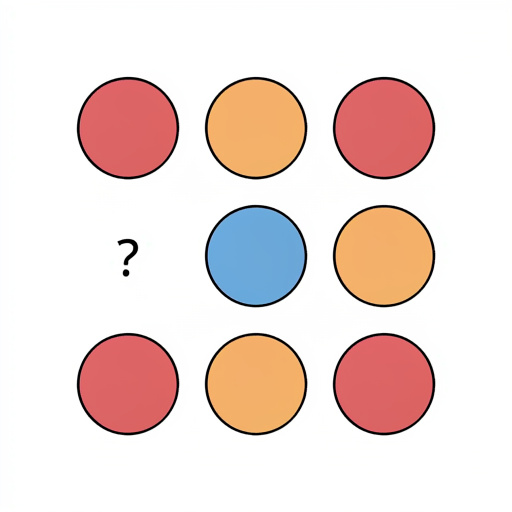

What is the color of the missing part denoted with a question mark?

# Options:
(A) green
(B) red
(C) orange
(D) yellow

# Pattern:
There are 16 squares arranged in a 4x4 grid. Some squares are filled with a color, while others are empty. The colors of the squares are as follows: [green, red, yellow, yellow, green, red, yellow, green, red, yellow, green, red, yellow, green, red, yellow, green, red, yellow, green, red, yellow, green, red, yellow, green, red, yellow, green, red, yellow, green, red, yellow, green, red, yellow, green, red, yellow, green, red, yellow, green, blue, green, red, yellow, green, blue, green, red, yellow, green, blue, green, red, yellow, green, blue, green, red, yellow, green, blue, green, red, yellow, green, blue, green, red, yellow, green, blue, green, red, yellow, green, blue, green, red, yellow, green, blue, green, red, yellow, green, blue, green, red, yellow, green, blue, green, red, yellow, green, blue, green, red, yellow, green, blue, green, red, yellow, g

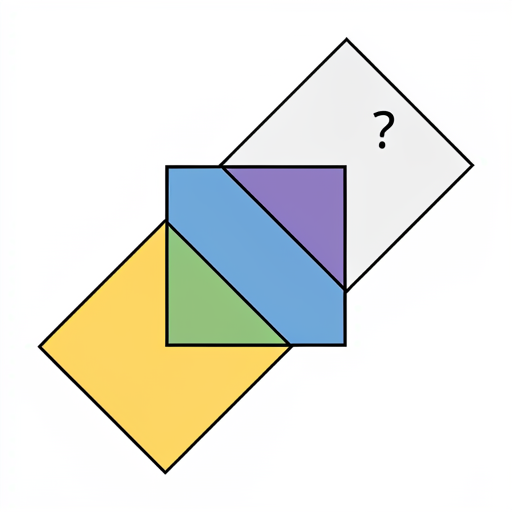

What is the missing color of the part denoted with a question mark?

# Options:
(A) green
(B) purple
(C) red
(D) yellow

# Pattern:
There are 16 squares arranged in a 4x4 grid. Some squares are filled with a color, while others are empty. The colors of the squares are as follows: [green, purple, red, yellow] [green, purple, red, yellow] [green, purple, red, yellow] [green, purple, red, yellow] [green, purple, red, yellow] [green, purple, red, yellow] [green, purple, red, yellow] [green, purple, red, yellow] [green, purple, red, yellow] [green, purple, red, yellow] [green, purple, red, yellow] [green, purple, red, yellow] [green, purple, red, yellow] [green, purple, red, yellow] [green, purple, red, yellow] [green, purple, red, yellow] 4*4
# Answer:
(A) green
(B) purple
(C) red
(D) yellow

# Note:
We observe that the pattern is a 4x4 grid of squares, where each square is either green, purple, red, or yellow. The colors of the squares are as follows: [green, purple, red, yellow] [green, 

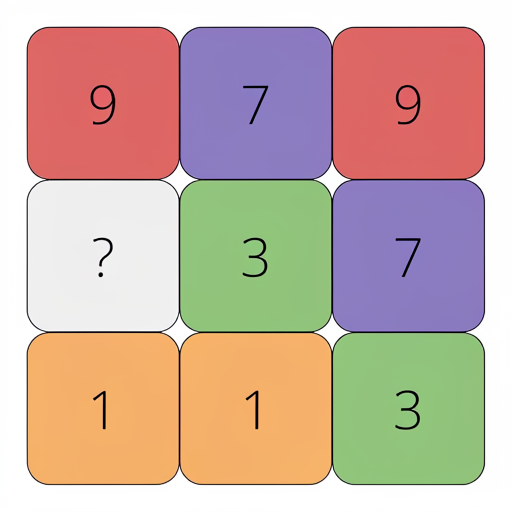

What is the missing color if the part denoted with the question mark has the number 3?

# Options:
(A) red
(B) purple
(C) green
(D) orange

# Pattern:
There is a color sequence: red, purple, green, orange. The number 3 is missing from the color sequence.

# Answer:
(A) red

# Note:
The answer is red since purple and orange are not in the color sequence.
# Note:
The answer is green since the number 3 is not in the color sequence.

# Note:
The answer is orange since the number 3 is not in the color sequence.

# Note:
The answer is orange since the number 3 is not in the color sequence.

# Note:
The answer is purple since the number 3 is not in the color sequence.

# Note:
The answer is red since the number 3 is not in the color sequence.

# Note:
The answer is green since the number 3 is not in the color sequence.

# Note:
The answer is orange since the number 3 is not in the color sequence.

# Note:
The answer is purple since the number 3 is not in the color sequence.

# Note:
The answe

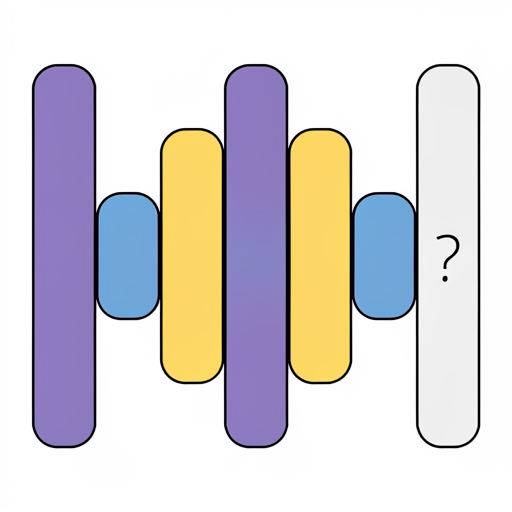

What is the missing color of the part denoted with a question mark?

# Options:
(A) green
(B) purple
(C) yellow
(D) orange

# Pattern:
There is a 10x10 grid of squares, with each square either green, purple, yellow, or orange. The grid is filled with these colors, except for the top-left square, which is purple. The grid is also missing a square in the bottom-right corner, which is orange. The grid is enclosed within a thick black border. There are no other objects or text present in the image.<|extra_204|>

 -------------------------------------------------- 



In [ ]:
for sample in eval_dataset:
    with torch.no_grad():
        outputs = model.generate(
            sample.input_ids.unsqueeze(0).to("cuda:0"),
            GENERATION_CONFIG,
            attention_mask=sample.attention_mask.unsqueeze(0).to("cuda:0"),
        )
    print(outputs.shape)
    
    output = processor.decode(outputs[0])
    for idx_j, im in enumerate(output):
        if not isinstance(im, Image.Image):
            print(im)
        else:
            im.show()

    print('\n', "-" * 50, '\n')

# Attention Map

In [6]:
model = AutoModelForCausalLM.from_pretrained(
    EMU_HUB,
    device_map="cuda:0",
    torch_dtype=torch.bfloat16,
    trust_remote_code=True,
    attn_implementation="eager"
).eval()

Loading checkpoint shards: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:06<00:00,  1.03it/s]


### (4214, 4214)

In [7]:
for sample in eval_dataset:
    break

In [8]:
with torch.no_grad():
    outputs = model(
        sample.input_ids.unsqueeze(0).to("cuda:0"),
        attention_mask=sample.attention_mask.unsqueeze(0).to("cuda:0"),
        output_attentions=True
    )

# Attentions weights after the attention softmax, used to compute the weighted average in the self-attention heads.
attentions = outputs.attentions # (batch_size, num_heads, sequence_length, sequence_length) x num_layers
attentions[0].shape

torch.Size([1, 32, 4214, 4214])

In [11]:
# layer_idx = -10
# head_idx = 30
# attention_map = attentions[layer_idx][0, head_idx].detach().cpu().to(torch.float32).numpy()

# layer_idx = -10
# best_head_idx = attentions[layer_idx][0].mean(axis=(1,2)).argmax() # max head
# attention_map = attentions[layer_idx][0][best_head_idx].detach().cpu().to(torch.float32).numpy()

# Average across all layers; Extract best head
avg_attention_map = torch.stack([attn[0].detach().cpu() for attn in attentions]).mean(dim=0)
best_head_idx = avg_attention_map.mean(dim=(1, 2)).argmax()
attention_map = avg_attention_map[best_head_idx].to(torch.float32).numpy()

In [12]:
attention_map.shape

(4214, 4214)

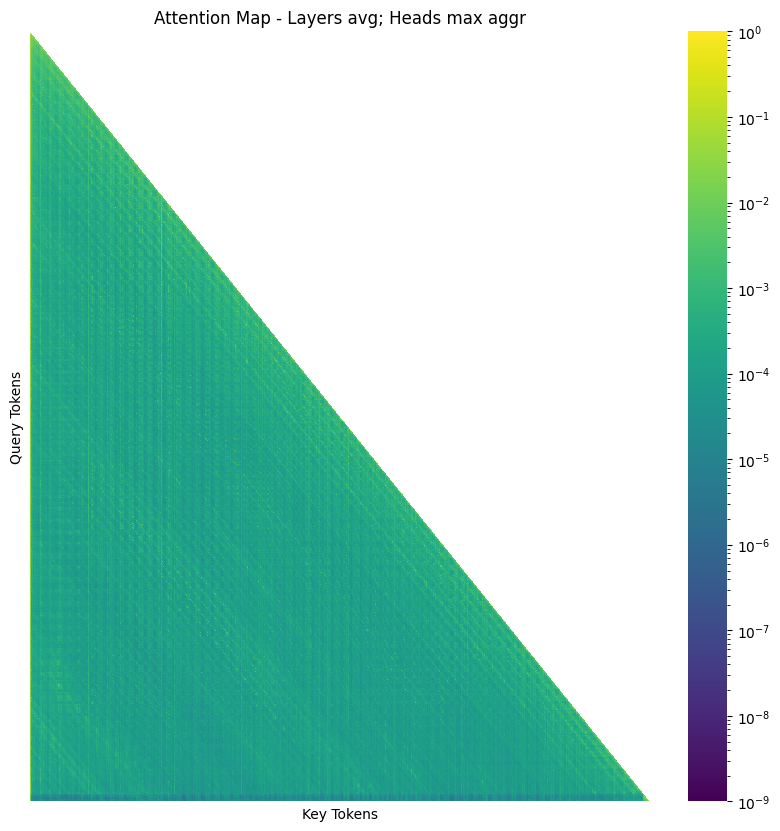

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# Plot heatmap
plt.figure(figsize=(10, 10))

sns.heatmap(
    attention_map,
    xticklabels=[],
    yticklabels=[],
    cmap="viridis",
    norm=LogNorm(vmin=attention_map.min()+1e-9, vmax=attention_map.max())
)

plt.title(f"Attention Map - Layers avg; Heads max aggr")
plt.xlabel("Key Tokens")
plt.ylabel("Query Tokens")

plt.show()

### (19, 6205)

In [7]:
GENERATION_CONFIG = GenerationConfig(
    use_cache=True,
    eos_token_id=model.config.eos_token_id,
    pad_token_id=model.config.pad_token_id,
    max_new_tokens=2000,
    do_sample=False,
    output_attentions=True,
    return_dict_in_generate=True,
)

In [8]:
for sample in eval_dataset:
    pass

In [9]:
with torch.no_grad():
    outputs = model.generate(
        sample.input_ids.unsqueeze(0).to("cuda:0"),
        attention_mask=sample.attention_mask.unsqueeze(0).to("cuda:0"),
        generation_config=GENERATION_CONFIG
    )
print(sample.input_ids.shape)
print(outputs.sequences.shape)

# Attentions weights after the attention softmax, used to compute the weighted average in the self-attention heads.
attentions = outputs.attentions # num_new_sequences x (num_layers x (batch_size, num_heads, generated_length, sequence_length))
len(attentions), attentions[-1][0].shape

The `seen_tokens` attribute is deprecated and will be removed in v4.41. Use the `cache_position` model input instead.
This is a friendly reminder - the current text generation call will exceed the model's predefined maximum length (5120). Depending on the model, you may observe exceptions, performance degradation, or nothing at all.


torch.Size([4206])
torch.Size([1, 6206])


(2000, torch.Size([1, 32, 1, 6205]))

In [25]:
from tqdm import tqdm
import numpy as np

# Average across all layers; Extract best head
avg_attention_map = torch.stack([attn[0].detach().cpu() for attn in attentions[0]]).mean(dim=0)
best_head_idx = avg_attention_map.mean(dim=(1, 2)).argmax()
attention_map = avg_attention_map[best_head_idx].to(torch.float32).numpy()

def process_attn(attentions, seq_ids):
    # Don't try to stack arrays of different sizes
    attention_maps_dict = {}
    
    for seq_id in tqdm(seq_ids):
        # Step 1: Find the best head by examining each layer separately
        num_layers = len(attentions[seq_id])
        layer_attn_sample = attentions[seq_id][0]
        num_heads = layer_attn_sample.shape[1]
        
        head_scores = torch.zeros(num_heads, device='cpu')
        
        # Process each layer one at a time to score heads
        for layer_idx in range(num_layers):
            layer_attn = attentions[seq_id][layer_idx]  # Shape: [batch_size, num_heads, gen_len, seq_len]
            
            # Process each head separately to avoid large tensors in memory
            for head_idx in range(num_heads):
                head_attn = layer_attn[:, head_idx]
                head_score = head_attn.mean().item()  # Single scalar value
                head_scores[head_idx] += head_score
            
            # Clear memory
            del layer_attn
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
        
        # Find best head
        best_head_idx = head_scores.argmax().item()
        
        # Step 2: Process only the best head from each layer
        sum_attention = None
        
        for layer_idx in range(num_layers):
            layer_attn = attentions[seq_id][layer_idx]  # Shape: [batch_size, num_heads, gen_len, seq_len]
            best_head_attn = layer_attn[:, best_head_idx].detach().cpu().float()
            
            if sum_attention is None:
                sum_attention = best_head_attn
            else:
                sum_attention += best_head_attn
            
            # Clear memory
            del layer_attn, best_head_attn
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
        
        # Average across layers
        avg_attention = sum_attention / num_layers
        avg_attention = avg_attention.squeeze()
        
        # Store as a dictionary with sequence ID as key
        attention_maps_dict[seq_id] = {
            'attention': avg_attention.numpy(),
            'shape': avg_attention.shape
        }
        
        # Clear memory
        del sum_attention, avg_attention
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
    
    return attention_maps_dict

attention_maps_dict = process_attn(attentions, seq_ids=range(100, 2000, 100))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.66it/s]


In [27]:
def combine_attention_maps(attention_maps_dict):
    # Find the maximum sequence length
    max_seq_length = max(data['shape'][-1] for data in attention_maps_dict.values())
    
    # Create padded results
    results = []
    seq_ids = []
    
    for seq_id, data in attention_maps_dict.items():
        attn_map = data['attention']
        current_seq_length = attn_map.shape[-1]
        
        # Pad if necessary
        if current_seq_length < max_seq_length:
            padding = np.zeros((max_seq_length - current_seq_length))
            padded_attn = np.hstack([attn_map, padding])
            results.append(padded_attn)
        else:
            results.append(attn_map)
        
        seq_ids.append(seq_id)
    
    return np.stack(results), seq_ids

attention_map, seq_ids = combine_attention_maps(attention_maps_dict)

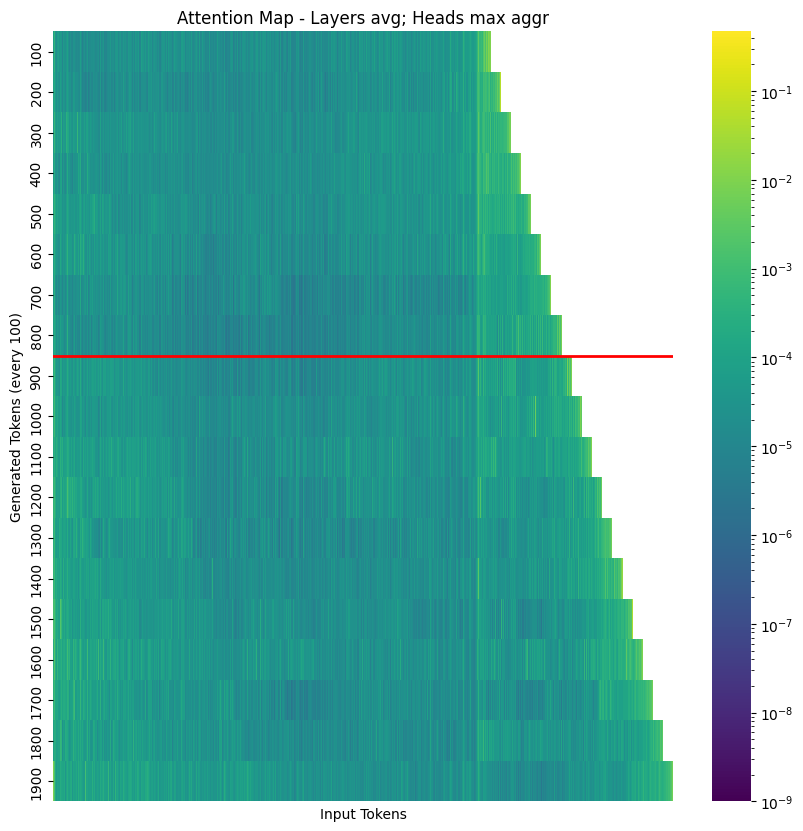

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# Plot heatmap
plt.figure(figsize=(10, 10))

sns.heatmap(
    attention_map,
    xticklabels=[],
    yticklabels=seq_ids,
    cmap="viridis",
    norm=LogNorm(vmin=attention_map.min()+1e-9, vmax=attention_map.max())
)

closest_idx = min(range(len(seq_ids)), key=lambda i: abs(seq_ids[i] - (5120-4206)))
plt.axhline(y=closest_idx, color='red', linestyle='-', linewidth=2)

plt.title(f"Attention Map - Layers avg; Heads max aggr")
plt.xlabel("Input Tokens")
plt.ylabel("Generated Tokens (every 100)")

plt.show()